# Detector network workflow

## Part 0. Dependencies

In [5]:
%%bash

pip install numpy seaborn sklearn-evaluation tensorflow
pip install git+git://github.com/edublancas/dstools
pip install git+git://github.com/paninski-lab/yass@dev-fix

  Using cached https://files.pythonhosted.org/packages/22/cc/ca70b78087015d21c5f3f93694107f34ebccb3be9624385a911d4b52ecef/tensorflow-1.12.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/35/6b/11530768cac581a12952a2aad00e1526b89d242d0b9f59534ef6e6a1752f/astor-0.7.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c2/f9/28787754923612ca9bfdffc588daa05580ed70698add063a5629d1a4209d/protobuf-3.6.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/20/c4/12e3e56473e52375aa29c4764e70d1b8f3efa6682bef8d0aae04fe335243/Werkzeug-0.14.1-py2.py3-none-any.whl
  Running setup.py bdist_wheel for absl-py: started
  Running setup.py bdist_wheel for absl-py: finished with status 'done'
  Stored in directory: /home/Edu/.cache/pip/wheels/18/ea/5e/e36e1b8739e78cd2eba0a08fdc602c2b16a4b263912af8cb64
Successfully built absl-py
  Cloning git://github.com/edublancas/dstools to /tmp/pip-req-build-iaktugw7
  Ru

## Part 1. Train/Test set creation

In [6]:
import datetime
import logging
from pathlib import Path
from os.path import expanduser
from os import path

import yass
from yass import read_config
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector
from yass.batch import RecordingsReader
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index


import seaborn as sns
import numpy as np
from dstools import plot
import sklearn_evaluation.plot as skplot

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [7]:
path_to_data = expanduser('~/data')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')

In [8]:
yass.set_config("../../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

### 1.1 Loading templates

In [9]:
raw_templates = np.load(Path(path_to_data, 'cat/templates-jul27-only-good.npy'))
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [10]:
# crop templates spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

/home/Edu/miniconda3/envs/test/lib/python3.6/site-packages/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


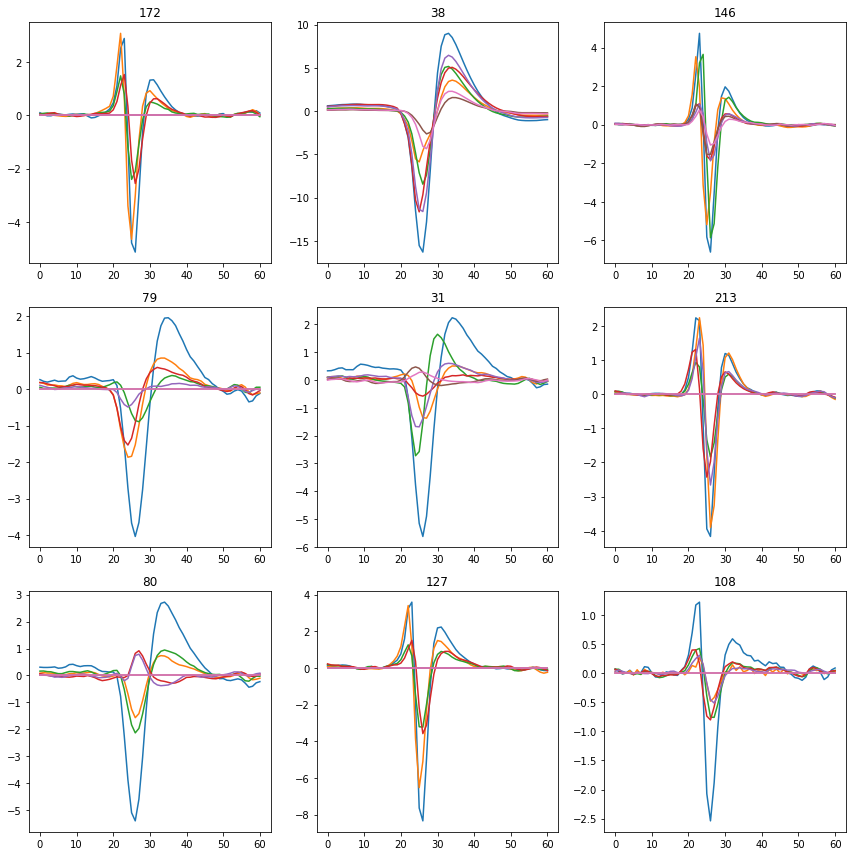

In [11]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

### 1.2 Estimating noise covariance structure

In [12]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [13]:
rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [14]:
min_amplitude = 4
max_amplitude = 60
n_clean_per_template = 200
n_positive_total = n_templates *  n_clean_per_template
n_collided_per_spike = 0
probs = [0.6, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]

### 1.3 Create dataset

In [15]:
(X, y) = make.training_data_detect(templates=templates,
                                    minimum_amplitude=min_amplitude,
                                    maximum_amplitude=max_amplitude,
                                    n_clean_per_template=n_clean_per_template,
                                    n_collided_per_spike=n_collided_per_spike,
                                    n_temporally_misaligned_per_spike=0.25,
                                    n_noise=int(n_positive_total * 0.5),
                                    n_spatially_misaliged_per_spike=0,
                                    spatial_SIG=spatial_sig,
                                    temporal_SIG=temporal_sig,
                                    add_noise_kwargs={'reject_cancelling_noise': False},
                                    from_templates_kwargs={'probabilities': probs})

In [16]:
X[y == 1].shape, X[y == 0].shape

((48000, 61, 7), (36000, 61, 7))

### 1.4 Plot some examples

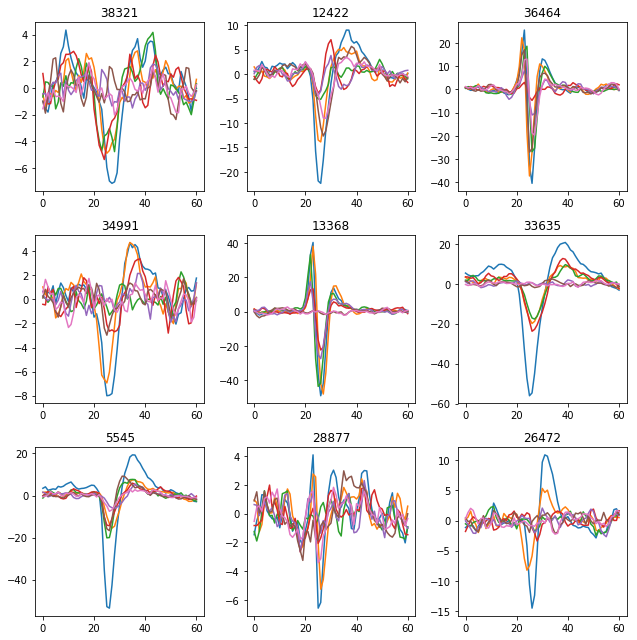

In [17]:
# positive examples (spikes)
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

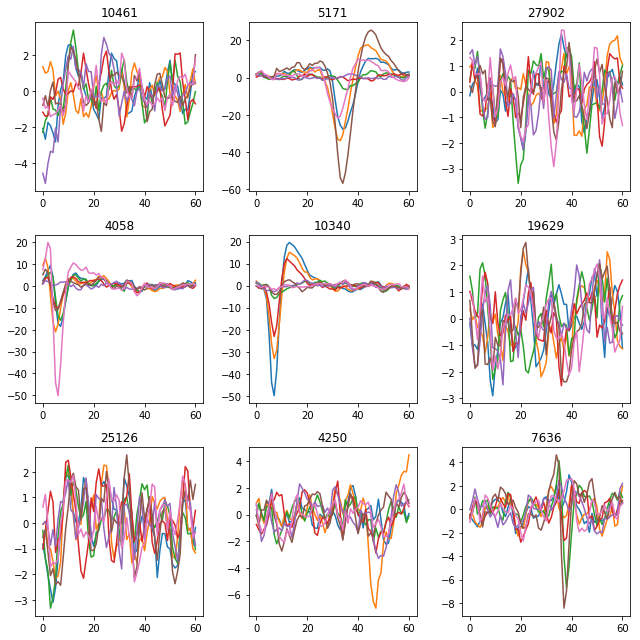

In [18]:
# negative examples: noise and non-centered spikes
plot.grid_from_array(X[y == 0], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

## Part 2. Network training

In [19]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.0001
filters_detect = [32, 32]

In [20]:
_, waveform_length, n_neighbors =  X.shape

detector = NeuralNetDetector('/tmp/my-detector-network.ckpt', filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(X, y)

61
30


Tr loss: 9.758995e-05, Val loss: 0.010827988: 100%|██████████| 5000/5000 [00:48<00:00, 120.42it/s] 


{'filters_size': [32, 32],
 'waveform_length': 61,
 'n_neighbors': 7,
 'name': 'my-detector-network',
 'tn': 0.9974076474400518,
 'fp': 0.0019445794846864365,
 'fn': 0.0027775205999444495,
 'tp': 0.9979165219806931,
 'acc': 0.9976984126984128,
 'prec': 0.9980551503785511,
 'rec': 0.9979165219806931,
 'metadata': {'yass_version': '0.10dev'}}

### Part 3. Network evaluation

In [21]:
preds = detector.predict(detector.x_test)

In [1]:
skplot.confusion_matrix(detector.y_test, preds, normalize=True, target_names=['Noise', 'Spike'])

NameError: name 'skplot' is not defined